# Implementing Kurtek 2017

We ran into an issue with SRVF-based dZ/dt registration. When the shape changes within an experiment, the b points are marked incorrectly in the shape that least resembles the Karcher mean.

Kurtek suggests using the square root of the derivative of the warping functions to create an "SRD."  

$$ \phi(\gamma) = \psi = \sqrt{\dot{\gamma}}$$

These SRD functions have a distance metric that is the arc-length between $\psi_1, \psi_2$

$$ d_{FR}\left(\gamma_1,\gamma_2\right)=d\left( \psi_1,\psi_2 \right) = \theta = \cos^{-1}(<\psi_1,\psi_2>) $$

where $<\cdot,\cdot>$ is the L2 inner product. Kurtek suggests computing the pairwise distances between all the SRD's. Here we borrow the code from SRVFDT to make some example functions:

Populating the interactive namespace from numpy and matplotlib


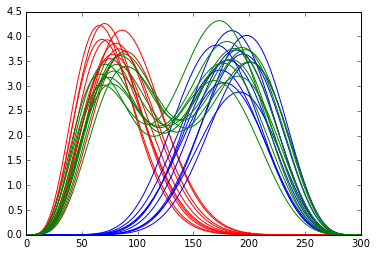

In [1]:
%pylab inline
import numpy as np
from scipy.stats import beta
# From SRVFDT
d = 300
n = 21
sig = 0.1
m = 1
warpRange = 1
b = 3
np.random.seed(0)

def make_samples(n_functions,peaks="both"):

    gamO = np.zeros((d,n_functions),dtype=np.float)
    a = np.linspace(-warpRange, warpRange,n+1)
    a = a[a!=0]
    t = np.linspace(-b,b,d)
    m=1
    f = np.zeros((d, n_functions),dtype=np.float)
    for i in range(n_functions):
        if a[i] != 0:
            gamO[:,i] = ((2*b)*(exp(a[i]*(t+b)/(2*b))-1)/(exp(a[i])-1)-b)
        else:
            gamO[:,i] = t
    t = (t+b)/(2*b);
    gamO = (gamO+b)/(2*b)

    for i in range(n_functions):
        first_peak = np.random.normal(m,sig) * beta.pdf(gamO[:,i],6,12)
        second_peak = np.random.normal(m,sig) * beta.pdf(gamO[:,i],12,6)
        if peaks == "second":
            f[:,i] = second_peak
        elif peaks == "first":
            f[:,i] = first_peak
        else:
            f[:,i] = first_peak + second_peak
    
    return f

first_peak = make_samples(10,"first")
second_peak = make_samples(10,"second")
two_peaks = make_samples(10,"both")
plot(first_peak,"r",second_peak,"b",two_peaks,"g")

original_functions = np.column_stack([first_peak,second_peak,two_peaks])


Perform the alignment using ``srvf_register``, my python wrapper for the SRVFDT c code. 

Computing Karcher mean of 30 functions in SRVF space...
updating step: r=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8


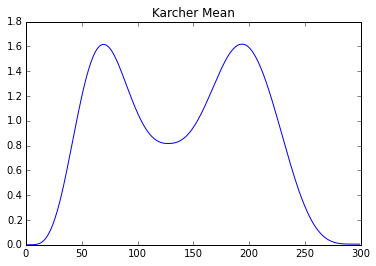

In [2]:
from srvf_register import RegistrationProblem

reg_prob = RegistrationProblem(
    original_functions,
    sample_times=np.arange(d,dtype=np.float),
    max_karcher_iterations = 15,
    lambda_value = 0.015,
    update_min = 0.01
)
reg_prob.run_registration_parallel()
all_karcher_mean = reg_prob.function_karcher_mean
all_srvf_karcher_mean = reg_prob.srvf_karcher_mean
plot(all_karcher_mean)
title("Karcher Mean");

This looks a lot like the double-peaked function. Here are the warping functions colored by their mode

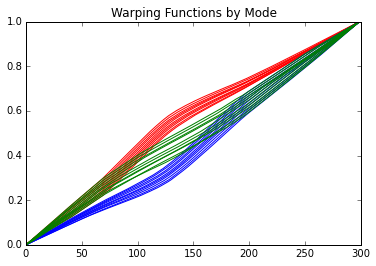

In [3]:
warps = reg_prob.mean_to_orig_warps
plot(warps[:,:10],"r",warps[:,10:20],"b",warps[:,20:],"g");
title("Warping Functions by Mode")

We can already see that there are some patterns in these warping functions. Let's see if we can get them into clusters.

## Calculating pairwise distances

Calculate the distance matrix on the warping functions. First make the SRDs and plot them.

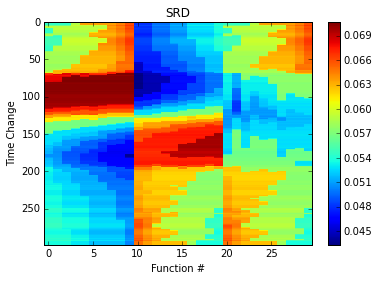

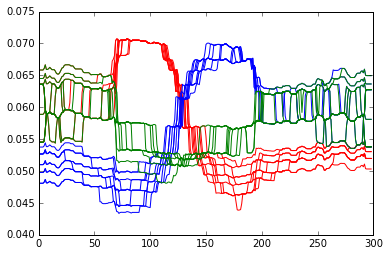

In [4]:
SRDs = np.sqrt(np.diff(warps,axis=0))
SRDs[np.logical_not(np.isfinite(SRDs))] = 0
imshow(SRDs,aspect="auto",interpolation="nearest")
colorbar()
title("SRD")
xlabel("Function #")
ylabel("Time Change")
figure()
plot(SRDs[:,:10],"r", SRDs[:,10:20], "b", SRDs[:,20:],"g");

## Hierarchical clustering on pairwise distances

This method uses hierarchical clustering to initialize clusters.

To do the hierarchical clustering we use the ``complete`` function, which implements the Maximum Linkage as specified on p509. Pairwise distances are calculated using Eq 4 on the SRDs of the warping functions.

/home/matt/miniconda2/envs/ets/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


<matplotlib.colorbar.Colorbar instance at 0x7fd8a052abd8>

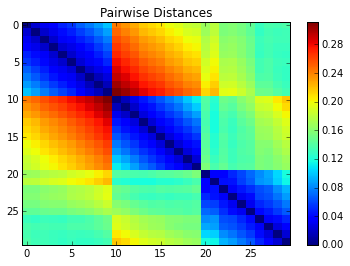

In [5]:
from sklearn.metrics.pairwise import pairwise_distances

def fisher_rao_dist(psi1, psi2):
    """ Equation 4 from Kurtek 2017"""
    return np.nan_to_num(np.arccos(np.inner(psi1,psi2)))

srd_pairwise = pairwise_distances(SRDs.T,metric=fisher_rao_dist)
imshow(srd_pairwise,aspect="auto",interpolation="nearest")
title("Pairwise Distances")
colorbar()

Sanity check: plot the dendrogram. We should see 3 clusters

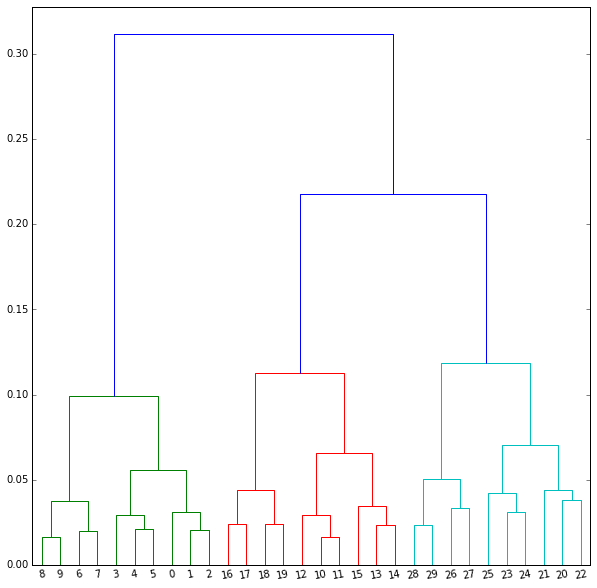

In [6]:
from scipy.cluster.hierarchy import complete, dendrogram
tri = srd_pairwise[np.triu_indices_from(srd_pairwise,1)]
linkage = complete(tri)
fig,ax = plt.subplots(figsize=(10,10))
dend = dendrogram(linkage,ax=ax,color_threshold=0.15)

## Do multiple modes exist?

We use the results of hierarchical clustering to test whether setting k=2 reduces variance by more than 30%. Here is a function that performs the inner loop of Algorithm 1.

In [9]:
def cluster_karcher_means(initial_assignments):
    cluster_means = []
    cluster_ids = np.unique(initial_assignments)
    warping_functions = np.zeros_like(SRDs)
    
    # Calculate a Karcher mean for each cluster
    for cluster_id in cluster_ids:
        cluster_id_mask = initial_assignments == cluster_id
        cluster_srds = SRDs[:,cluster_id_mask]
        
        # If there is only a single SRD in this cluster, it is the mean
        if cluster_id_mask.sum() == 1:
            cluster_means.append(cluster_srds)
            #continue
        
        # Run group registration to get Karcher mean
        cluster_reg = RegistrationProblem(
                cluster_srds,
                sample_times=np.arange(d-1, dtype=np.float),
                max_karcher_iterations = 15,
                lambda_value = 0.015,
                update_min = 0.01
        )
        cluster_reg.run_registration_parallel()
        cluster_means.append(cluster_reg.function_karcher_mean)
        warping_functions[:,cluster_id_mask] = cluster_reg.mean_to_orig_warps
        
    # There are now k cluster means, which is closest for each SRD?
    # Also save its distance to its cluster's Karcher mean
    srd_cluster_assignments = []
    srd_cluster_distances = []
    for srd in SRDs.T:
        distances = [fisher_rao_dist(cluster_mean,srd) for cluster_mean in cluster_means]
        cluster_num = np.argmin(distances)
        srd_cluster_assignments.append(cluster_num)
        srd_cluster_distances.append(fisher_rao_dist(cluster_means[cluster_num],srd))
        
    return srd_cluster_assignments, np.array(srd_cluster_distances)**2, cluster_means, warping_functions



Evaluate this with $k=1$

Computing Karcher mean of 30 functions in SRVF space...
updating step: r=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14


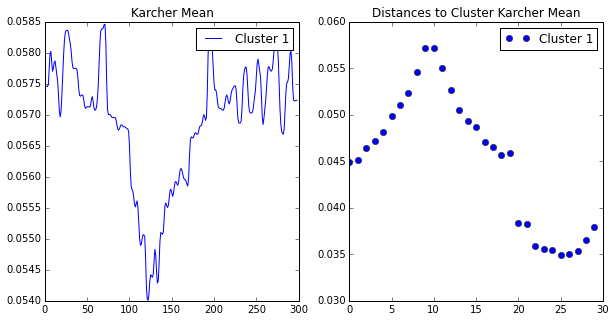

In [10]:
ids_k1, distances_k1, cluster_means_k1, warping_funcs_k1 = cluster_karcher_means(
            np.ones(SRDs.shape[1],dtype=np.int))
fig,axes = plt.subplots(ncols=2,figsize=(10,5))
axes[0].plot(cluster_means_k1[0],label="Cluster 1")
axes[0].set_title("Karcher Mean")
axes[0].legend()

axes[1].plot(distances_k1,'bo', label="Cluster 1")
axes[1].set_title("Distances to Cluster Karcher Mean")
axes[1].legend()

To evaluate with $k=2$, get cluster assignments setting a maxium of 2 clusters

Computing Karcher mean of 10 functions in SRVF space...
updating step: r=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
Computing Karcher mean of 20 functions in SRVF space...
updating step: r=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14


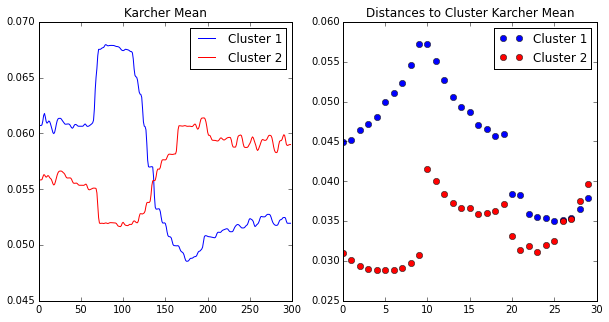

In [11]:
from scipy.cluster.hierarchy import fcluster
k2_hc_assignments = fcluster(linkage,2,criterion="maxclust")

ids_k2, distances_k2, cluster_means_k2, warping_funcs_k2 = cluster_karcher_means(
            k2_hc_assignments)
fig,axes = plt.subplots(ncols=2,figsize=(10,5))

axes[0].plot(cluster_means_k2[0],'b',label="Cluster 1")
axes[0].plot(cluster_means_k2[1],'r',label="Cluster 2")
axes[0].set_title("Karcher Mean")
axes[0].legend()

axes[1].plot(distances_k1,'bo', label="Cluster 1")
axes[1].plot(distances_k2,'ro', label="Cluster 2")

axes[1].set_title("Distances to Cluster Karcher Mean")
axes[1].legend()

Are the distances reduced by 30%?

In [12]:
print "distances reduced by %d percent" % ((1-np.var(distances_k2)/np.var(distances_k1)) * 100)

distances reduced by 71 percent


this is more than the 30% needed. So we decide that these distributions have multiple modes. 

## Determining the correct number of clusters and running kmeans

Since we detected multiple modes, we find the "correct" number of clusters by calculating the silhouette score.

Here we calculate the silhouette scores over a couple k's

In [ ]:
from sklearn.metrics import silhouette_samples

# Calculate the silhouette scores for a couple different k's
silhouette_scores = []
for k in range(1,4):
    cluster_assignments = fcluster(linkage,k+1,criterion="maxclust")
    silhouette_scores.append(
        silhouette_samples(srd_pairwise, cluster_assignments, metric="precomputed")
    )
    plot(silhouette_scores[-1],'o-',
         label="k=%d (%.2f)" % (k+1, silhouette_scores[-1].mean()))
legend(loc=3)
ylabel("Sample silhouette score")


In parenthesis are the mean silhouette scores for each k. It has correctly identified that there are 3 modes. 

## Finalizing the cluster assignments

Now that we know we want to set $k=3$, run Algorithm 1 with $k$ set to 3

In [ ]:
k3_hc_assignments = fcluster(linkage,3,criterion="maxclust")

ids_k3, distances_k3, cluster_means_k3, warping_funcs_k3 = cluster_karcher_means(
            k3_hc_assignments)
fig,axes = plt.subplots(ncols=2,figsize=(10,5))

axes[0].plot(cluster_means_k3[0],'b',label="Cluster 1")
axes[0].plot(cluster_means_k3[1],'r',label="Cluster 2")
axes[0].plot(cluster_means_k3[2],'g',label="Cluster 3")

axes[0].set_title("Karcher Mean")
axes[0].legend()

axes[1].plot(distances_k1,'bo', label="k=1")
axes[1].plot(distances_k2,'ro', label="k=2")
axes[1].plot(distances_k3,'go', label="k=3")


axes[1].set_title("Distances to Cluster Karcher Mean")
axes[1].legend()

In [5]:
%qtconsole

I think this works.